# Unified Age & Gender Baseline Analysis

This notebook evaluates how well **Age** and **Gender** alone can distinguish between Patients and Healthy controls. 
It uses a robust Machine Learning pipeline with Lasso regularization and explicit dataset balancing.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve

import config
importlib.reload(config)
from config import ANALYSIS_MODE as analysis_mode
from config import SPECIFIC_GROUP as specific_group

## 1. Data Loading and Balancing

We load the clinical data and ensure we have an equal number of samples in both groups for a fair comparison.

In [43]:
clinical_path = "/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/filtered_clinical_characteristics.csv"
df_raw = pd.read_csv(clinical_path, sep=";")

# Filter by config mode
if analysis_mode == "specific_vs_healthy":
    df = df_raw[
        (df_raw["Patient Type"] == specific_group) |
        (df_raw["Patient Type"].str.lower() == "healthy")
    ].copy()
else:
    df = df_raw.copy()

# Drop missing data for demographic features
df = df[df["Age at Diagnosis"].notna() & df["Gender"].isin(["M", "F"])].copy()

# Balancing: Undersample the majority group (usually Healthy)
cancer_df = df[df["Patient Type"].str.lower() != "healthy"]
healthy_df = df[df["Patient Type"].str.lower() == "healthy"]

n_cancer = len(cancer_df)
n_healthy = len(healthy_df)
print(n_cancer)
print(n_healthy)

if n_healthy > n_cancer:
    healthy_df = healthy_df.sample(n=n_cancer, random_state=42)
elif n_cancer > n_healthy:
    cancer_df = cancer_df.sample(n=n_healthy, random_state=42)

df_balanced = pd.concat([cancer_df, healthy_df]).copy()
print(f"Balanced Dataset Size: {len(df_balanced)} (Ratio 1:1)")

24
108
Balanced Dataset Size: 48 (Ratio 1:1)


## 2. Distribution Check (KDE Plot)

Let's visualize if there's an obvious age difference between the groups.

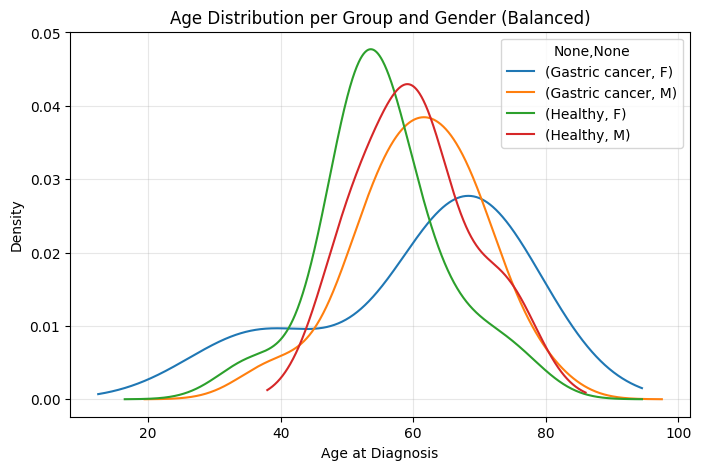

In [44]:
plt.figure(figsize=(8, 5))
df_balanced.groupby(['Patient Type', 'Gender'])['Age at Diagnosis'].plot.kde(legend=True)
plt.title("Age Distribution per Group and Gender (Balanced)")
plt.xlabel("Age at Diagnosis")
plt.grid(alpha=0.3)
plt.show()

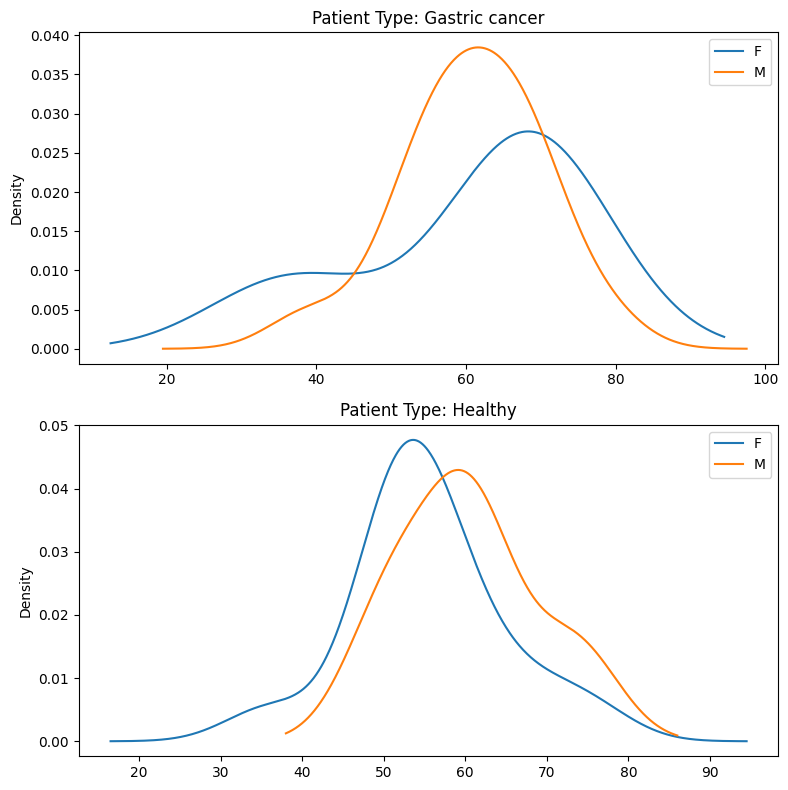

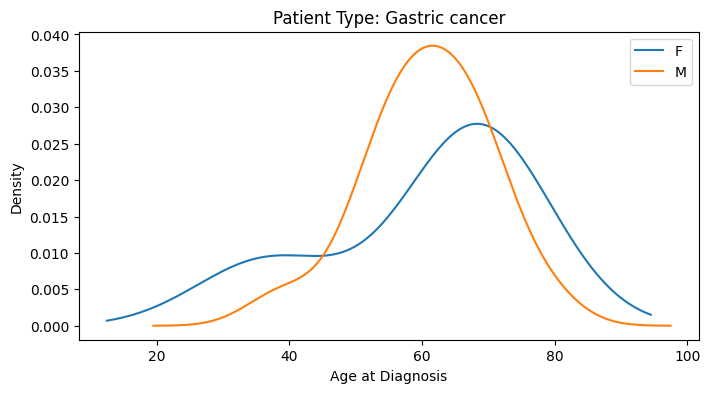

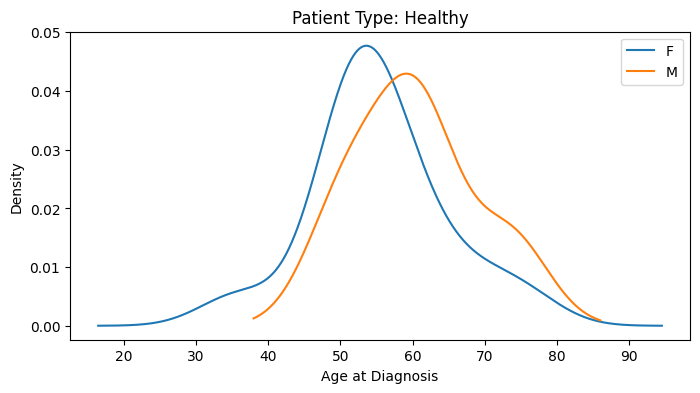

In [45]:
import matplotlib.pyplot as plt

groups = df_balanced.groupby('Patient Type')
fig, axes = plt.subplots(nrows=len(groups), figsize=(8, 4 * len(groups)), squeeze=False)

for ax, (name, group) in zip(axes.flatten(), groups):
    group.groupby('Gender')['Age at Diagnosis'].plot.kde(ax=ax, legend=True, title=f"Patient Type: {name}")

plt.tight_layout()

for name, group in df_balanced.groupby('Patient Type'):
    plt.figure(figsize=(8, 4))
    group.groupby('Gender')['Age at Diagnosis'].plot.kde(legend=True, title=f"Patient Type: {name}")
    plt.xlabel('Age at Diagnosis')
    plt.show()



## 3. Lasso Logistic Regression Pipeline

We use `LogisticRegressionCV` to find the optimal L1 (Lasso) penalty via cross-validation.

In [46]:
# Preprocessing
df_balanced['Gender_enc'] = df_balanced['Gender'].map({"M": 0, "F": 1})
df_balanced['target'] = (df_balanced['Patient Type'].str.lower() != "healthy").astype(int)

#X = df_balanced[['Age at Diagnosis', 'Gender_enc']]
X = df_balanced[['Age at Diagnosis']]

y = df_balanced['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Pipeline definition
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso_cv", LogisticRegressionCV(
        Cs=np.logspace(-4, 4, 30),
        penalty="l1",
        solver="liblinear",
        cv=5,
        scoring="roc_auc",
        random_state=42
    ))
])

pipeline.fit(X_train, y_train)

y_prob = pipeline.predict_proba(X_test)[:, 1]
final_auc = roc_auc_score(y_test, y_prob)

print(f"\nTest AUC: {final_auc:.4f}")

/labmed/workspace/lotta/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1780: FutureWarning: The default value for l1_ratios will change from None to (0.0,) in version 1.10. From version 1.10 onwards, only array-like with values in [0, 1] will be allowed, None will be forbidden. To avoid this warning, explicitly set a value, e.g. l1_ratios=(0,).
  warnings.warn(
/labmed/workspace/lotta/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1811: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratios' instead. Use l1_ratios=(0,) instead of penalty='l2'  and l1_ratios=(1,) instead of penalty='l1'.
  warnings.warn(
/labmed/workspace/lotta/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1823: FutureWarning: The fitted attributes of LogisticRegressionCV will be simplified in scikit-learn 1.10 to remove redundancy. Set`use_leg


Test AUC: 0.5000


## 4. Evaluation Results

Model Coefficients:
            Feature  Coefficient
0  Age at Diagnosis          0.0


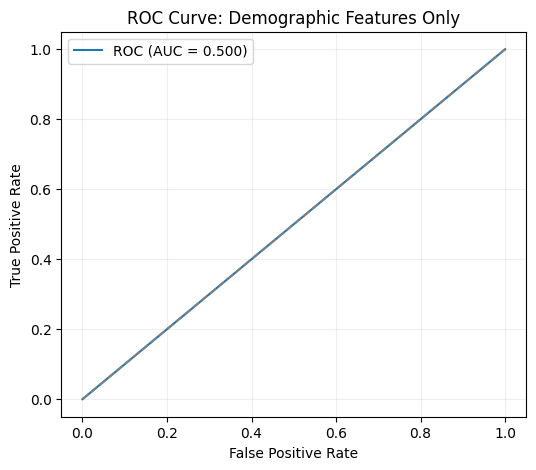

In [47]:
# Coefficients
model = pipeline.named_steps['lasso_cv']
coeffs = pd.DataFrame({
    'Feature': X.columns, 
    'Coefficient': model.coef_[0]
})
print("Model Coefficients:")
print(coeffs)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC = {final_auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curve: Demographic Features Only")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.2)
plt.show()